In [1]:
%matplotlib inline

import torch
from torch import nn
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from datasets import SubjObjDataset
from vectorizers import IndexVectorizer
from models import TextCNN
from train_utils import fit
from torch.backends import cudnn
from glove_utils import load_glove_embeddings

In [2]:
data_path = '/home/austin/data/SUBJDATA/'
glove_path = '/home/austin/data/glove/glove.6B.50d.txt'
cudnn.benchmark = True

In [3]:
vectorizer = IndexVectorizer(min_frequency=4)

In [4]:
train = SubjObjDataset(data_path+'train.csv', vectorizer)
val = SubjObjDataset(data_path+'val.csv', train.vectorizer)
test = SubjObjDataset(data_path+'test.csv', train.vectorizer)

In [5]:
train.corpus.head()

,sentences,labels,tokens,vectors
0,"finally , he gets an offer to make a big film .",subjective,"[finally, ,, he, gets, an, offer, to, make, a,...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0,..."
1,kay has since returned to the comforts of civi...,subjective,"[kay, has, since, returned, to, the, comforts,...","[0, 14, 15, 16, 8, 17, 0, 18, 0, 19, 20, 21, 2..."
2,watching the film is like reading a times port...,objective,"[watching, the, film, is, like, reading, a, ti...","[38, 17, 12, 39, 40, 41, 10, 42, 43, 18, 44, 3..."
3,"in the affable maid in manhattan , jennifer lo...",objective,"[in, the, affable, maid, in, manhattan, ,, jen...","[26, 17, 0, 51, 26, 52, 3, 0, 0, 53, 54, 55, 5..."
4,shaun brumder is a local surfer kid from orang...,subjective,"[shaun, brumder, is, a, local, surfer, kid, fr...","[0, 0, 39, 10, 68, 0, 69, 70, 0, 71, 48, 72, 1..."


In [6]:
word2idx = train.vectorizer.word2idx

In [7]:
embeddings = load_glove_embeddings(glove_path, word2idx)

In [8]:
embeddings


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.1627 -0.3727 -0.0225  ...  -0.8456 -0.2768 -0.3669
          ...             ⋱             ...          
 1.1784 -0.1128 -0.8695  ...  -0.5821  0.6375  0.3348
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
-0.4731  0.2630 -0.9713  ...   0.0200 -0.1370  0.4085
[torch.FloatTensor of size 4233x50]

In [9]:
model = TextCNN(train.vectorizer.vocabulary_size, 50, train.vectorizer.maxlen)
model.cuda()

TextCNN (
  (embedding): Embedding(4233, 50, padding_idx=0)
  (conv): MultiKernelConv (
    (conv3x1): Conv1d(50, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv4x1): Conv1d(50, 8, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv5x1): Conv1d(50, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (pool): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear (1248 -> 32)
  (dropout): Dropout (p = 0.5)
  (output): Linear (32 -> 2)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [11]:
history = fit(model, train, criterion, optimizer, validation_data=val, batch_size=32, nb_epoch=5)

Train on 6400 samples, Validate on 1600 samples


[Epoch 1 - loss: 0.6009 - acc: 0.6647 - val_loss: 0.4426 - val_acc: 0.7837]


[Epoch 2 - loss: 0.3858 - acc: 0.8356 - val_loss: 0.3656 - val_acc: 0.8275]


[Epoch 3 - loss: 0.2824 - acc: 0.8905 - val_loss: 0.3329 - val_acc: 0.8506]


[Epoch 4 - loss: 0.2094 - acc: 0.9231 - val_loss: 0.3435 - val_acc: 0.8581]


[Epoch 5 - loss: 0.1464 - acc: 0.9502 - val_loss: 0.3651 - val_acc: 0.8675]



## Overfit in 3 epochs with very small model.

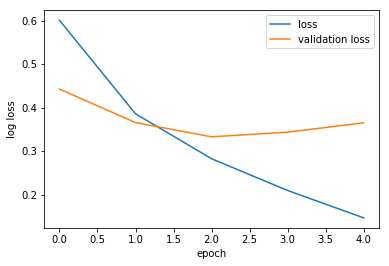

In [12]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('log loss')
plt.legend();

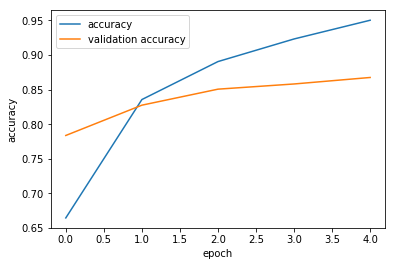

In [13]:
plt.plot(history['acc'], label='accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

## Initialize with glove vectors

In [14]:
model = TextCNN(train.vectorizer.vocabulary_size, 50, train.vectorizer.maxlen, embeddings)
model.cuda()

TextCNN (
  (embedding): Embedding(4233, 50, padding_idx=0)
  (conv): MultiKernelConv (
    (conv3x1): Conv1d(50, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv4x1): Conv1d(50, 8, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv5x1): Conv1d(50, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (pool): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear (1248 -> 32)
  (dropout): Dropout (p = 0.5)
  (output): Linear (32 -> 2)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [16]:
history = fit(model, train, criterion, optimizer, validation_data=val, batch_size=32, nb_epoch=5)

Train on 6400 samples, Validate on 1600 samples


[Epoch 1 - loss: 0.4267 - acc: 0.8025 - val_loss: 0.2793 - val_acc: 0.8862]


[Epoch 2 - loss: 0.2446 - acc: 0.9102 - val_loss: 0.2370 - val_acc: 0.9000]


[Epoch 3 - loss: 0.1833 - acc: 0.9356 - val_loss: 0.2112 - val_acc: 0.9137]


[Epoch 4 - loss: 0.1281 - acc: 0.9575 - val_loss: 0.2302 - val_acc: 0.9163]


[Epoch 5 - loss: 0.0905 - acc: 0.9742 - val_loss: 0.2570 - val_acc: 0.9137]



## 91.63 validation accuracy vs 86.75 without glove

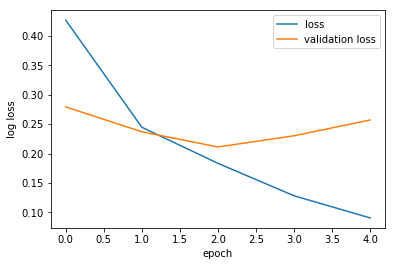

In [17]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('log loss')
plt.legend();

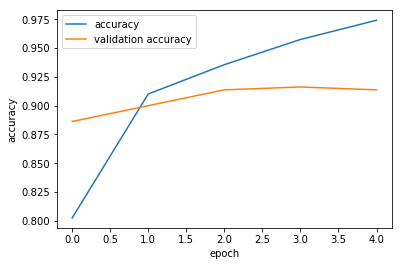

In [18]:
plt.plot(history['acc'], label='accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();